In [9]:
import nbodykit
import numpy as np
from nbodykit.lab import *
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import matplotlib
import os
import time

# loading in sims + calculating power spectra

direc = "/mnt/extraspace/damonge/MarkedPk/fiducial_512/"
Pk_direc= "mnt/zfsusers/jesscowell/MarkedCorr/Data/COLA_sims/Jess_Pk/"
Pk_dd={}
Pk_dm={}
Pk_mm={}
COLA = {}


from Pk_tools import Fourier,get_Pk, smooth_field, mark_10
# for x in range(101, 200):
#     d["string{0}".format(x)] = "Hello" 
# COLA/seed<seed>/sn_fiducial_512_seed00<seed>_<snapnum>.<part>

#  Gadget1Catalog(filename)



R=10 #smoothing radius
# fil = filters.Gaussian(R)    
    
for seed in range(100, 200):
    catalog= Gadget1Catalog(direc+f"COLA/seed{seed}/sn_fiducial_512_seed00{seed}_001.0")
    for i in range(1, 64):
        new = Gadget1Catalog(direc+f"COLA/seed{seed}/sn_fiducial_512_seed00{seed}_001.{i}")
        catalog= transform.ConcatenateSources(catalog, new)
#         print('done')
    start=time.time()
    mesh = catalog.to_mesh(Nmesh=256)
    rfield = np.array(mesh.paint(mode='real') )#get real field
    k, kfield = Fourier(rfield, Nmesh=256)
    x, smoothed_rfield= Fourier(smooth_field(k, kfield, R), Nmesh=256)
    
#     print('smoothed')
    
    marked_field = rfield * mark_10(5, 0.25, smoothed_rfield)  #marked field  of field
    marked_kfield= Fourier(marked_field)
    
    power_auto = get_Pk(kfield, k)
    power_marked_auto = get_Pk(marked_kfield, k)
#     power_cross = FFTPower(marked_kfield, k, second = kfield)
    
    Pk_dd[f'seed{seed}'] = power_auto
    
    np.save(Pk_direc+f'seed{seed}_Pk_dd', power_auto)
#     power_auto.save(Pk_direc+f'seed{seed}_Pk_dd')
    np.save(Pk_direc+f'seed{seed}_Pk_mm', power_marked_auto)
#     power_marked_auto.save(Pk_direc+f'seed{seed}_Pk_mm')
#     power_cross.save(Pk_direc+f'seed{seed}_Pk_dm')
    np.save(Pk_direc+f'seed{seed}_Pk_dm', power_cross)
    
    Pk_dm[f'seed{seed}'] = power_cross
    Pk_mm[f'seed{seed}'] = power_marked_auto
    
    print(time.time()-start)
# COLA_smoothed={}

    
    
    
    
    
    
#     catalog = COLA[f'seed{seed}']
#     mesh = catalog.to_mesh(Nmesh=512)
#     COLA_painted[f'seed{seed}'] = mesh.paint()
    
        
# print(COLA)





# loading in power spectra 

In [5]:
#TO DO: CHANGE THIS TO MY PK

Pk_dd_dict={}
Pk_dm_dict={}
Pk_mm_dict={}
COLA = {}
start = time.time()
for seed in range(100, 200):
    Pk_dd_dict[f'seed{seed}'] = FFTPower.load(f'/mnt/extraspace/jesscowell/MarkedCorr/COLA_sims/seed{seed}_Pk_dd')
    Pk_dm_dict[f'seed{seed}'] = FFTPower.load(f'/mnt/extraspace/jesscowell/MarkedCorr/COLA_sims/seed{seed}_Pk_dm')
    Pk_mm_dict[f'seed{seed}'] = FFTPower.load(f'/mnt/extraspace/jesscowell/MarkedCorr/COLA_sims/seed{seed}_Pk_mm')
print(time.time()-start)

## sum over simulations


Pk_mm_pow = []
Pk_dd_pow = []
Pk_dm_pow = []
for seed in range(100, 200):
    #for now just look at orig. case
    Pk_dd_pow.append(Pk_dd_dict[f'seed{seed}'].power['power'])
    Pk_dd_k = (Pk_dd_dict[f'seed{seed}'].power['k'])
    Pk_dd_mode = Pk_dd_dict[f'seed{seed}'].power['modes']

    Pk_mm_pow.append(Pk_mm_dict[f'seed{seed}'].power['power'])
    Pk_mm_k = Pk_mm_dict[f'seed{seed}'].power['k']
    Pk_mm_mode= Pk_mm_dict[f'seed{seed}'].power['modes']
    
    
    Pk_dm_pow.append(Pk_dm_dict[f'seed{seed}'].power['power'])
    Pk_dm_k = Pk_dm_dict[f'seed{seed}'].power['k']
    Pk_dm_mode = Pk_dm_dict[f'seed{seed}'].power['modes']

    
    
mean_Pk_dd = np.mean(Pk_dd_pow, axis=0)
mean_Pk_mm = np.mean(Pk_mm_pow, axis=0)
mean_Pk_dm = np.mean(Pk_dm_pow, axis=0)

print(np.shape(Pk_dd_pow), np.shape(mean_Pk_dd))



0.9717295169830322
(100, 256) (256,)


# calculating covariance matrices

In [17]:
covmat=np.zeros((255*3, 255*3)) #this will be the actual covariance
th_mat = np.zeros((255*3, 255*3)) #this will be the theoretical covariance
np_mat = np.zeros((255*3, 255*3)) #this is a test with the numpy covariance



Pk_pow = np.array([np.array(Pk_dd_pow)[:,1:],np.array(Pk_dm_pow)[:,1:], np.array(Pk_mm_pow)[:,1:]])
Pk_mean = np.array([mean_Pk_dd[1:], mean_Pk_dm[1:], mean_Pk_mm[1:]])
Pk_mode = [Pk_dd_mode[1:],Pk_dm_mode[1:], Pk_mm_mode[1:]]
Pk_k = [Pk_dd_k, Pk_dm_k, Pk_mm_k]
names2= ['$\delta \delta$', '$\delta \Delta$', '$\Delta \Delta$']

names= ['dd', 'dm', 'mm']
order = {'dd': 0, 'dm': 1, 'mm': 2, 'md': 1}

print(Pk_pow[2].shape,Pk_pow.shape, Pk_mean.shape)
print(Pk_pow[1][2][3])
# print(np.array(Pk_pow[1][1:]).shape)
# print(np.array(Pk_pow[1][1:])[1][1])

(100, 255) (3, 100, 255) (3, 255)
(-772.8359980620155-4.3617662533309107e-07j)


/tmp/ipykernel_5286/500384565.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  cov_sec[k][q]=cov/(99)
/tmp/ipykernel_5286/500384565.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)


True

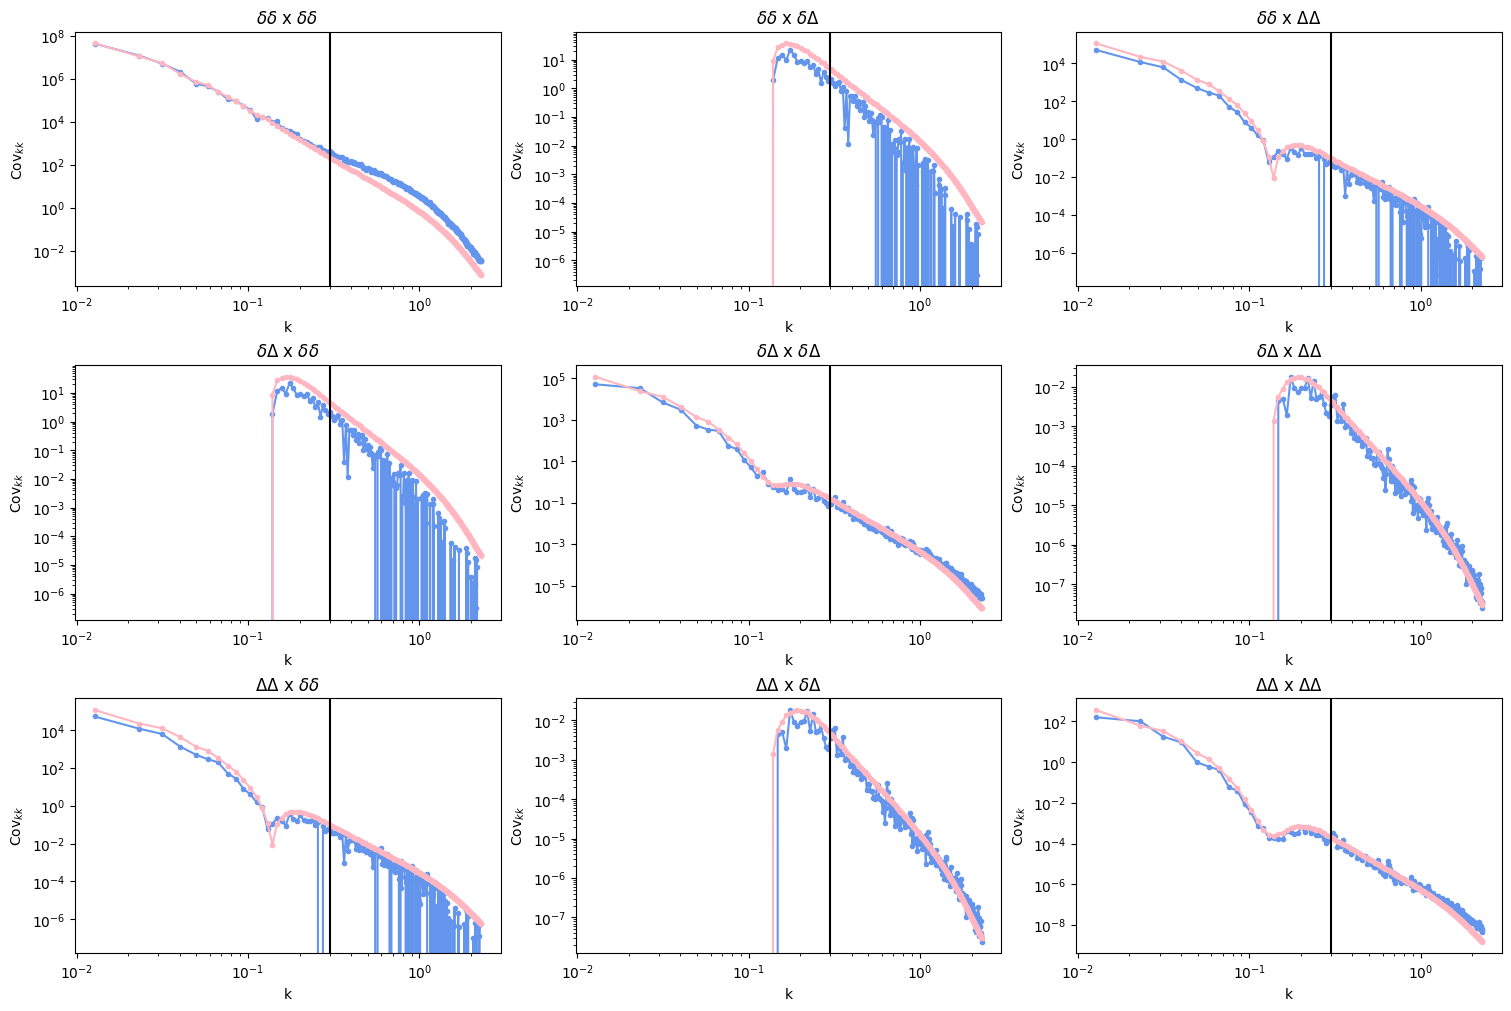

In [26]:
th_mat_blocks = []

# print(Pk_mode[0])
# print(Pk_dm_pow)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,10) ,layout="constrained")        
        
for i in range (0,3):
    th_mat_blocks.append([])
    for j in range(0, 3):
        Pk_pow_i = Pk_pow[i]; Pk_pow_j = Pk_pow[j]
        Pk_mean_i =  Pk_mean[i]; Pk_mean_j =  Pk_mean[j]
        cov_sec = np.zeros((255,255))
        for k in range(0,255):
            for q in range(0,255): 
                cov=0
                for s in range(0,99):
#                 for one  simulation
                    cov += ((Pk_pow_i)[s][k]-Pk_mean_i[k])*(Pk_pow_j[s][q]-Pk_mean_j[q])
                cov_sec[k][q]=cov/(99)

#         numpy_cov= np.cov(np.array(np.real(Pk_pow_i)).T, np.array(np.real(Pk_pow_j)).T)[255:511, 0:255]
        a, b = names[i]
        c, d = names[j]
        cov_sec_th = np.diag(((Pk_mean[order[a+c]]*Pk_mean[order[b+d]]+
                               Pk_mean[order[a+d]]*Pk_mean[order[b+c]])/Pk_mode[0]))
#         cov_sec_th = np.diag(Pk_mean[i][1:]*Pk_mean[j][1:]/Pk_mode[i][1:])
#         print(Pk_mean[i])
#         print(Pk_pow_i[0][1])
        th_mat_blocks[i].append(cov_sec_th)
        start_idx = i*255; end_idx = start_idx + 255    
        start_jdx = j*255; end_jdx = start_jdx + 255 
        ###plot check 
        axs[i,j].plot(Pk_k[i][1:], np.diag(cov_sec), label = 'Covariance from COLA Sims', marker='.', color='cornflowerblue') # is Pk_k = Pk_j?
#         axs[i,j].plot(Pk_k[i], np.diag(numpy_cov), label='numpy',marker='.')
        axs[i,j].plot(Pk_k[i][1:], np.diag(cov_sec_th), '-', label='Theoretical Approx.',marker='.', color='lightpink')
        
#         axs[i,j].plot(Pk_k[i][1:], np.diag(cov_sec_th)-np.diag(cov_sec), label = 'diff',marker='.') # is Pk_k = Pk_j?
#         axs[i,j].set_xlim(0.0001,.5)
      
        axs[i,j].set_xlabel('k')
        axs[i,j].set_ylabel('Cov$_{kk} $')
#         axs[i,j].legend()
#         plt.loglog()
#         axs[i, j].annotate
#         (f'{names[i]} x {names[j]}', )
#                                transform=axs[row, col].transAxes,
#                                ha='center', va='center', fontsize=18,
#                                color='darkgrey')
        
        
        axs[i,j].title.set_text(f'{names2[i]} x {names2[j]} ')
#         axs[i,j].set_yscale('log')
#         plt.plot(cov_sec plt.plot(Pk_k, np.diag(covmat), label = 'actual')
        axs[i,j].loglog() 
        axs[i,j].axvline(x=0.3, c='k')
    
        ##########
        th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)
        covmat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(cov_sec)
#         np_mat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(numpy_cov)
        inv=(np.linalg.inv(cov_sec_th))
        np.save('theory_cov'+f'{names[i]} x {names[j]} ', cov_sec_th)
        np.save('actual_cov'+f'{names[i]} x {names[j]} ', cov_sec)

#         print(inv)
        
# plt.show()
plt.savefig('Covariance_check.pdf')

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
check_symmetric(covmat)




# explicitly check the difference


/tmp/ipykernel_41639/3994007002.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  cov_sec[k][q]=cov/(99)
/tmp/ipykernel_41639/3994007002.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)


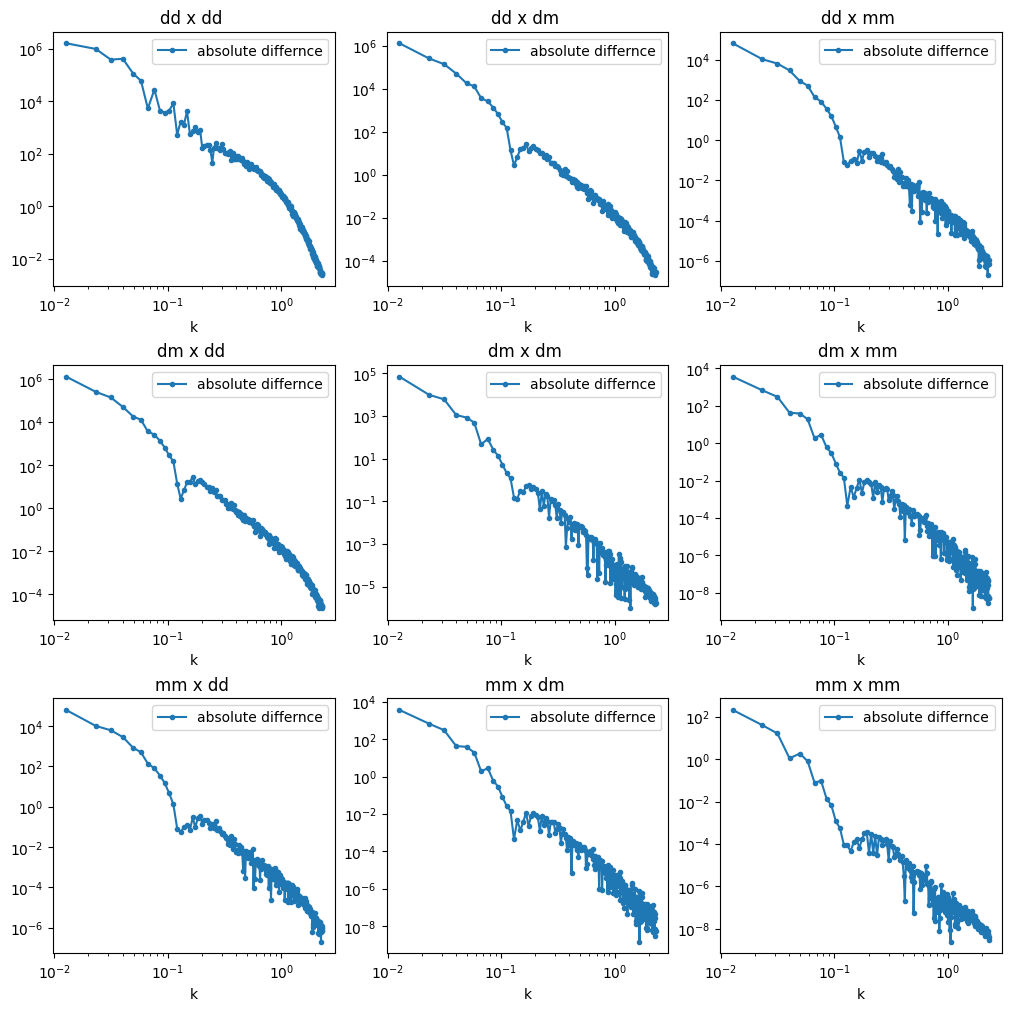

True

In [7]:
th_mat_blocks = []

# print(Pk_mode[0])
# print(Pk_dm_pow)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10,10) ,layout="constrained")        
        
for i in range (0,3):
    th_mat_blocks.append([])
    for j in range(0, 3):
        Pk_pow_i = Pk_pow[i]; Pk_pow_j = Pk_pow[j]
        Pk_mean_i =  Pk_mean[i]; Pk_mean_j =  Pk_mean[j]
        cov_sec = np.zeros((255,255))
        for k in range(0,255):
            for q in range(0,255): 
                cov=0
                for s in range(0,99):
#                 for one  simulation
                    cov += ((Pk_pow_i)[s][k]-Pk_mean_i[k])*(Pk_pow_j[s][q]-Pk_mean_j[q])
                cov_sec[k][q]=cov/(99)

#         numpy_cov= np.cov(np.array(np.real(Pk_pow_i)).T, np.array(np.real(Pk_pow_j)).T)[255:511, 0:255]
        a, b = names[i]
        c, d = names[j]
        cov_sec_th = np.diag(((Pk_mean[order[a+c]]*Pk_mean[order[b+d]]+
                               Pk_mean[order[a+d]]*Pk_mean[order[b+c]])/Pk_mode[0]))
#         cov_sec_th = np.diag(Pk_mean[i][1:]*Pk_mean[j][1:]/Pk_mode[i][1:])
#         print(Pk_mean[i])
#         print(Pk_pow_i[0][1])
        th_mat_blocks[i].append(cov_sec_th)
        start_idx = i*255; end_idx = start_idx + 255    
        start_jdx = j*255; end_jdx = start_jdx + 255 
        ###plot check 
        axs[i,j].plot(Pk_k[i][1:], abs(np.diag(cov_sec)-np.diag(cov_sec_th)), label = 'absolute differnce', marker='.') # is Pk_k = Pk_j?
#         axs[i,j].plot(Pk_k[i], np.diag(numpy_cov), label='numpy',marker='.')
#         axs[i,j].set_xlim(0.0001,.5)
      
       
        axs[i,j].legend()
        plt.loglog()
#         axs[i, j].annotate
#         (f'{names[i]} x {names[j]}', )
#                                transform=axs[row, col].transAxes,
#                                ha='center', va='center', fontsize=18,
#                                color='darkgrey')
        
        
        axs[i,j].title.set_text(f'{names[i]} x {names[j]} ')
#         axs[i,j].set_yscale('log')
#         plt.plot(cov_sec plt.plot(Pk_k, np.diag(covmat), label = 'actual')
        axs[i,j].loglog()    
        axs[i,j].set_xlabel('k')    
    
        ##########
        th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)
        covmat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(cov_sec)
#         np_mat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(numpy_cov)
        inv=(np.linalg.inv(cov_sec_th))
        np.save('theory_cov'+f'{names[i]} x {names[j]} ', cov_sec_th)
        np.save('actual_cov'+f'{names[i]} x {names[j]} ', cov_sec)

#         print(inv)
        
plt.show()

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
check_symmetric(covmat)




# plot diff as a percentage

/tmp/ipykernel_41639/2046225802.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  cov_sec[k][q]=cov/(99)
/tmp/ipykernel_41639/2046225802.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)


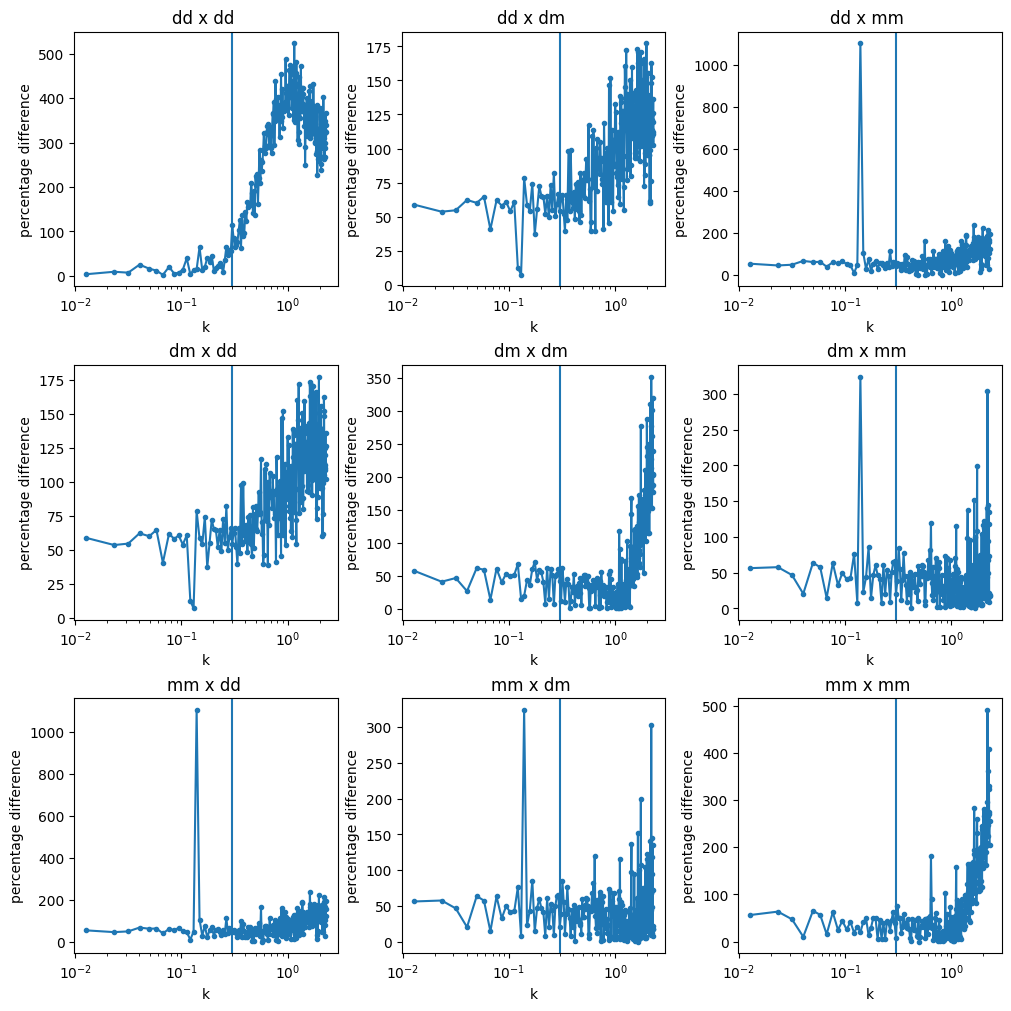

True

In [13]:
th_mat_blocks = []

# print(Pk_mode[0])
# print(Pk_dm_pow)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10,10) ,layout="constrained")        
        
for i in range (0,3):
    th_mat_blocks.append([])
    for j in range(0, 3):
        Pk_pow_i = Pk_pow[i]; Pk_pow_j = Pk_pow[j]
        Pk_mean_i =  Pk_mean[i]; Pk_mean_j =  Pk_mean[j]
        cov_sec = np.zeros((255,255))
        for k in range(0,255):
            for q in range(0,255): 
                cov=0
                for s in range(0,99):
#                 for one  simulation
                    cov += ((Pk_pow_i)[s][k]-Pk_mean_i[k])*(Pk_pow_j[s][q]-Pk_mean_j[q])
                cov_sec[k][q]=cov/(99)

#         numpy_cov= np.cov(np.array(np.real(Pk_pow_i)).T, np.array(np.real(Pk_pow_j)).T)[255:511, 0:255]
        a, b = names[i]
        c, d = names[j]
        cov_sec_th = np.diag(((Pk_mean[order[a+c]]*Pk_mean[order[b+d]]+
                               Pk_mean[order[a+d]]*Pk_mean[order[b+c]])/Pk_mode[0]))
#         cov_sec_th = np.diag(Pk_mean[i][1:]*Pk_mean[j][1:]/Pk_mode[i][1:])
#         print(Pk_mean[i])
#         print(Pk_pow_i[0][1])
        th_mat_blocks[i].append(cov_sec_th)
        start_idx = i*255; end_idx = start_idx + 255    
        start_jdx = j*255; end_jdx = start_jdx + 255 
        ###plot check 
        axs[i,j].plot(Pk_k[i][1:], 100*abs((np.diag(cov_sec)-np.diag(cov_sec_th))/np.diag(cov_sec_th)), label = 'percentage differnce', marker='.') # is Pk_k = Pk_j?
#         axs[i,j].plot(Pk_k[i], np.diag(numpy_cov), label='numpy',marker='.')
#         axs[i,j].set_xlim(0.0001,.5)
      
        axs[i,j].set_xlabel('k') 
        axs[i,j].set_ylabel('percentage difference')    
        
#         axs[i,j].legend()
#         plt.loglog()
#         axs[i, j].annotate
#         (f'{names[i]} x {names[j]}', )
#                                transform=axs[row, col].transAxes,
#                                ha='center', va='center', fontsize=18,
#                                color='darkgrey')
        
        
        axs[i,j].title.set_text(f'{names[i]} x {names[j]} ')
        axs[i,j].set_xscale('log')
        axs[i,j].axvline(x=0.3, c='k')
#         plt.plot(cov_sec plt.plot(Pk_k, np.diag(covmat), label = 'actual')
#         axs[i,j].loglog()       
        ##########
        th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)
        covmat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(cov_sec)
        
#         plt.imshow(covmat)
#         np_mat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(numpy_cov)
        inv=(np.linalg.inv(cov_sec_th))
#         np.save('theory_cov'+f'{names[i]} x {names[j]} ', cov_sec_th)
#         np.save('actual_cov'+f'{names[i]} x {names[j]} ', cov_sec)

#         print(inv)

plt.show()

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
check_symmetric(covmat)




/tmp/ipykernel_41639/921721939.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  cov_sec[k][q]=cov/(99)
/tmp/ipykernel_41639/921721939.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)


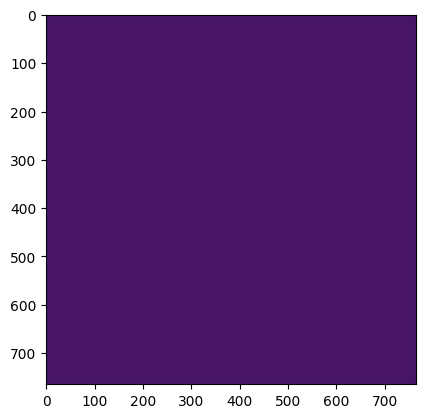

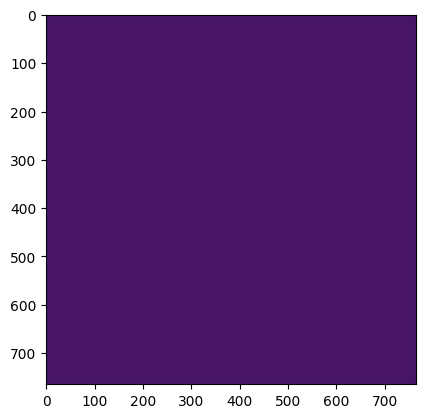

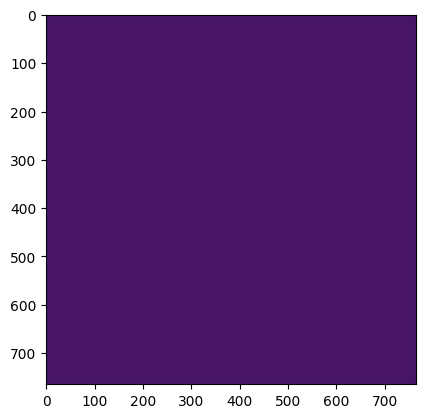

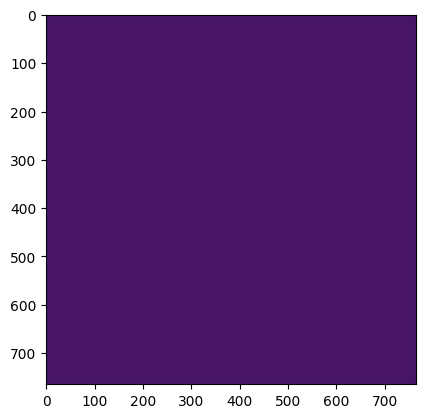

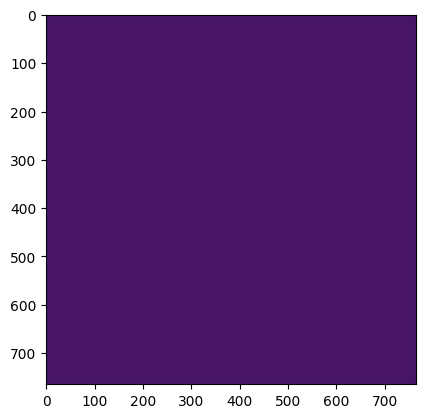

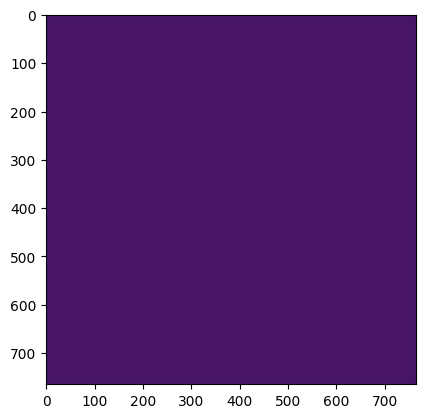

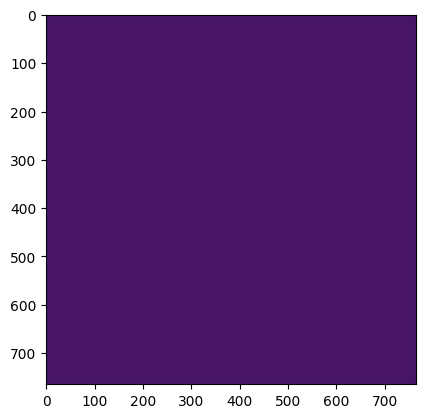

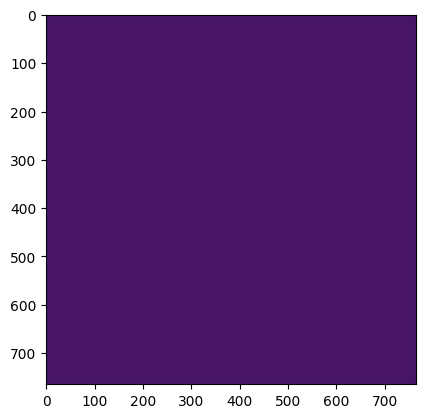

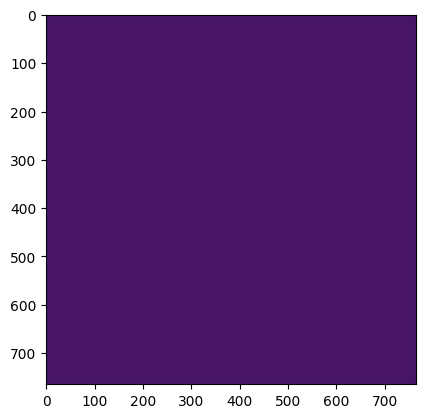

True

In [12]:
th_mat_blocks = []

# print(Pk_mode[0])
# print(Pk_dm_pow)
# fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10,10) ,layout="constrained")        
        
for i in range (0,3):
    th_mat_blocks.append([])
    for j in range(0, 3):
        Pk_pow_i = Pk_pow[i]; Pk_pow_j = Pk_pow[j]
        Pk_mean_i =  Pk_mean[i]; Pk_mean_j =  Pk_mean[j]
        cov_sec = np.zeros((255,255))
        for k in range(0,255):
            for q in range(0,255): 
                cov=0
                for s in range(0,99):
#                 for one  simulation
                    cov += ((Pk_pow_i)[s][k]-Pk_mean_i[k])*(Pk_pow_j[s][q]-Pk_mean_j[q])
                cov_sec[k][q]=cov/(99)

#         numpy_cov= np.cov(np.array(np.real(Pk_pow_i)).T, np.array(np.real(Pk_pow_j)).T)[255:511, 0:255]
        a, b = names[i]
        c, d = names[j]
        cov_sec_th = np.diag(((Pk_mean[order[a+c]]*Pk_mean[order[b+d]]+
                               Pk_mean[order[a+d]]*Pk_mean[order[b+c]])/Pk_mode[0]))

        th_mat_blocks[i].append(cov_sec_th)
        start_idx = i*255; end_idx = start_idx + 255    
        start_jdx = j*255; end_jdx = start_jdx + 255 
        ###plot check 
     
        ##########
        th_mat[start_idx:end_idx][:, start_jdx:end_jdx] = np.array(cov_sec_th)
        covmat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(cov_sec)
        
        plt.imshow(covmat)
        plt.show()
#         np_mat[start_idx:end_idx][:, start_jdx:end_jdx]  = np.array(numpy_cov)
        inv=(np.linalg.inv(cov_sec_th))
#         np.save('theory_cov'+f'{names[i]} x {names[j]} ', cov_sec_th)
#         np.save('actual_cov'+f'{names[i]} x {names[j]} ', cov_sec)

#         print(inv)
        
plt.show()

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
check_symmetric(covmat)




TypeError: Image data of dtype complex128 cannot be converted to float

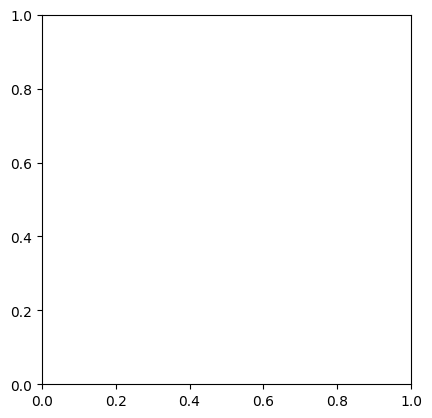

In [9]:
plt.imshow(cov)